# IMA205 Challenge

Louis Martinez

For the whole notebook we will denote the research papers as follows :

- [[1]](https://link.springer.com/book/10.1007/978-3-319-75541-0) : Statistical Atlases and Computational Models of the Heart. ACDC and MMWHS Challenges
- [[2]](https://www.sciencedirect.com/science/article/pii/S0010482505000430) : Automatic segmentation of the left ventricle cavity and myocardium in MRI data

In [2]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import os

## Loading data

We first define some utility functions

In [97]:
def load_mris(dir):
    """Function to load all mris from test and train directories"""
    mris = []
    for sample in os.listdir(dir):
        mri_dir = os.path.join(dir, sample)
        sample_mris = []
        for mri in os.listdir(mri_dir):
            # Load mri
            mri_data = nib.load(os.path.join(mri_dir, mri)).get_fdata()
            sample_mris.append(mri_data)

        mris.append(sample_mris)

    return np.array(mris, dtype=object)


def plot_slices(slices, title=None):
    """Function to plot slices of a MRI"""
    n_slices=slices.shape[0]
    n_rows, n_cols=0, 0
    if n_slices%5==0:
        n_rows=n_slices//5
    else:
        n_rows=n_slices//5+1

    if n_slices<5:
        n_cols=n_slices
    else:
        n_cols=5

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
    ax=axes.ravel()
    for i, slice in enumerate(slices):
        ax[i].pcolormesh(slice)
        ax[i].set_title(f'Slice {i}')
    if title:
        fig.suptitle(title, fontsize=20)
    plt.show()

def normalize(img):
    return ((img - img.min())/ (img.max() - img.min()))*255

In [4]:
# LOAD CSV FILES

train_csv='metaDataTrain.csv'
test_csv='metaDataTest.csv'

df_train=pd.read_csv(train_csv)
df_test=pd.read_csv(test_csv)

X_train=df_train[['Height','Weight']].to_numpy()
y_train=df_train[['Category']].to_numpy().ravel()
X_test=df_test[['Height','Weight']].to_numpy()

X_cat = [X_train[y_train == i] for i in range(y_train.max() + 1)] # split by category


In [5]:
# LOAD MRIs

train_dir = 'Train'
test_dir = 'Test'

mri_train = load_mris(train_dir)
mri_test = load_mris(test_dir)

For ease of use, we change the format the MRIs as (num_slices, height, width). This way we just need to write `plt.pcolor(mri[i])` instead of `plt.pcolor(mri[:,:,i])`

In [6]:
# Format MRI and segmentation masks as (num_slices, height, width)
n_train_samples, n_train_mri = mri_train.shape
n_test_samples, n_test_mri = mri_test.shape


for i in range(n_train_samples):
    for j in range(n_train_mri):
        mri_train[i][j] = np.transpose(mri_train[i][j], (2, 0, 1))

for i in range(n_test_samples):
    for j in range(n_test_mri):
        mri_test[i][j] = np.transpose(mri_test[i][j], (2, 0, 1))

print(f'Train MRI shape: {mri_train.shape}')
print(f'Test MRI shape: {mri_test.shape}')
print(f'MRI shape : {mri_train[0][0].shape}')

Train MRI shape: (100, 4)
Test MRI shape: (50, 4)
MRI shape : (10, 216, 256)


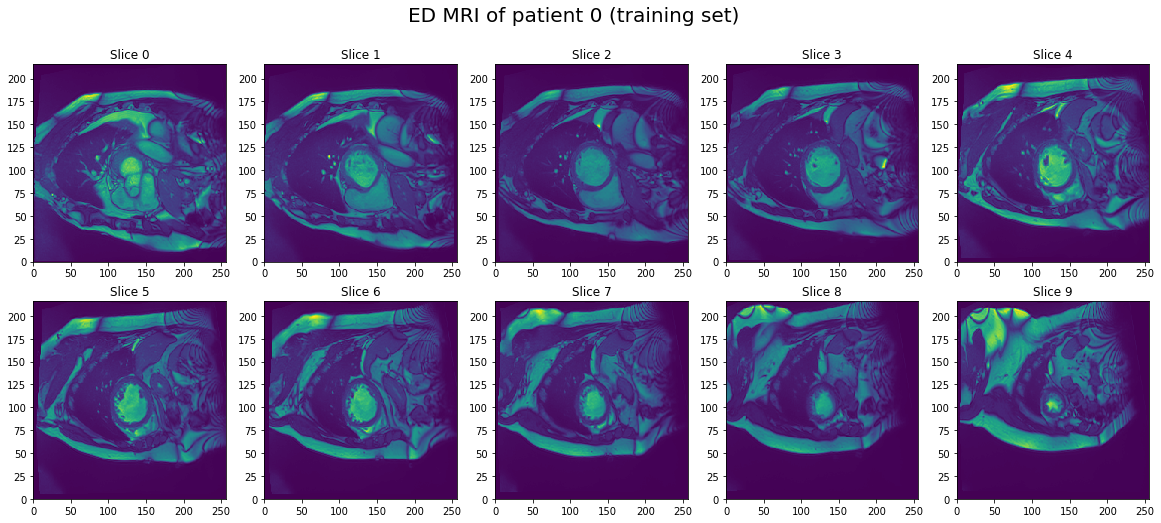

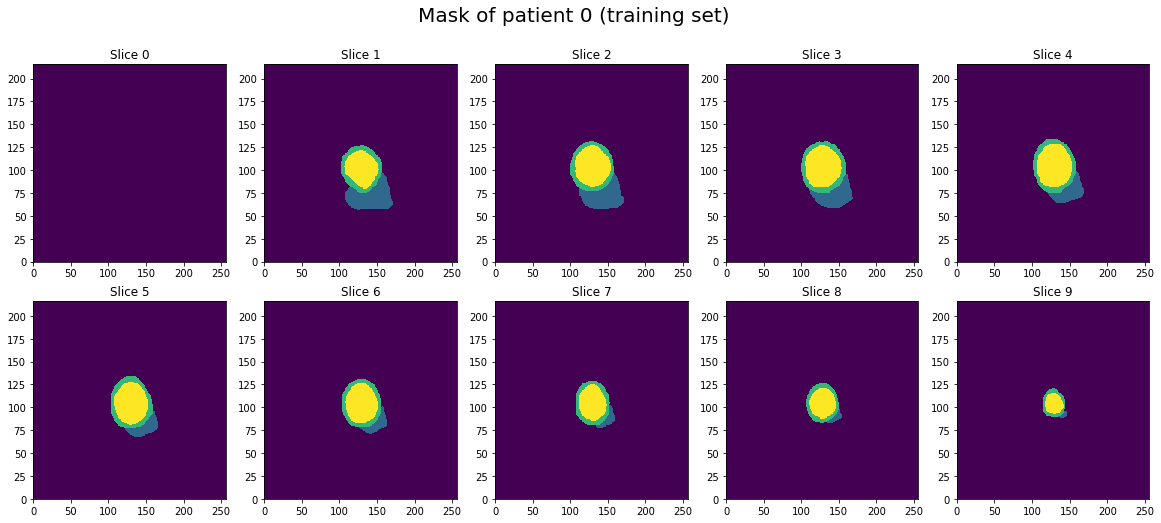

In [98]:
patient_idx=0
mri_idx=0
mask_idx=mri_idx+1

plot_slices(mri_train[patient_idx][mri_idx], title=f'ED MRI of patient {patient_idx} (training set)')
plot_slices(mri_train[patient_idx][mask_idx], title=f'Mask of patient {patient_idx} (training set)')

## Left ventricle segmentation

This step is actually essential to explain as best as possible the variability of heart structure. Indeed [1] mentions that the most interesting features (that can be accessed with the provided data) explaining the variability of the structure depend on LV volume.

For consistency, we will segment LV on test mris by using the fact that it is always inside the myocardium which is already segmented.

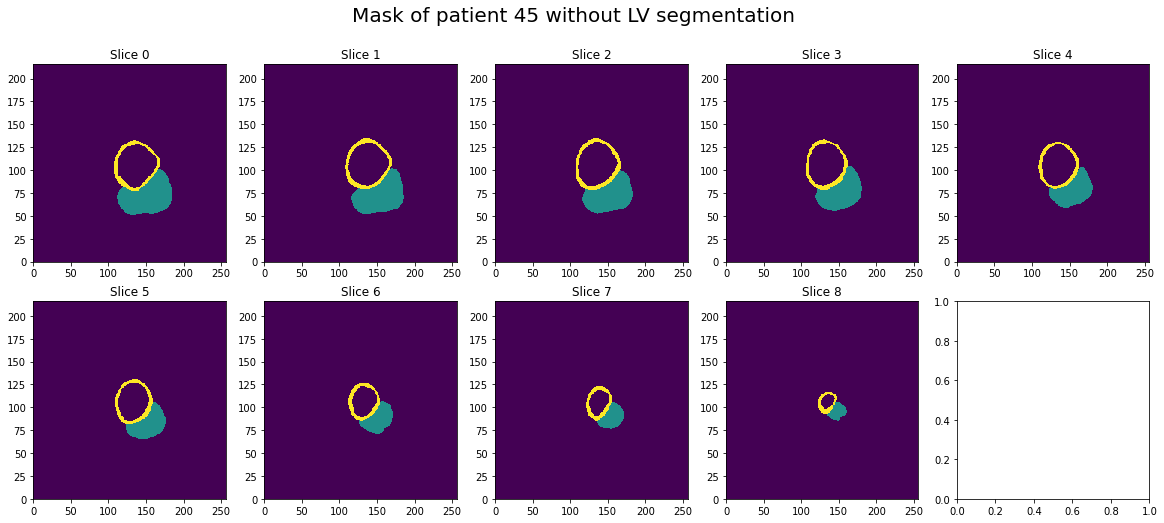

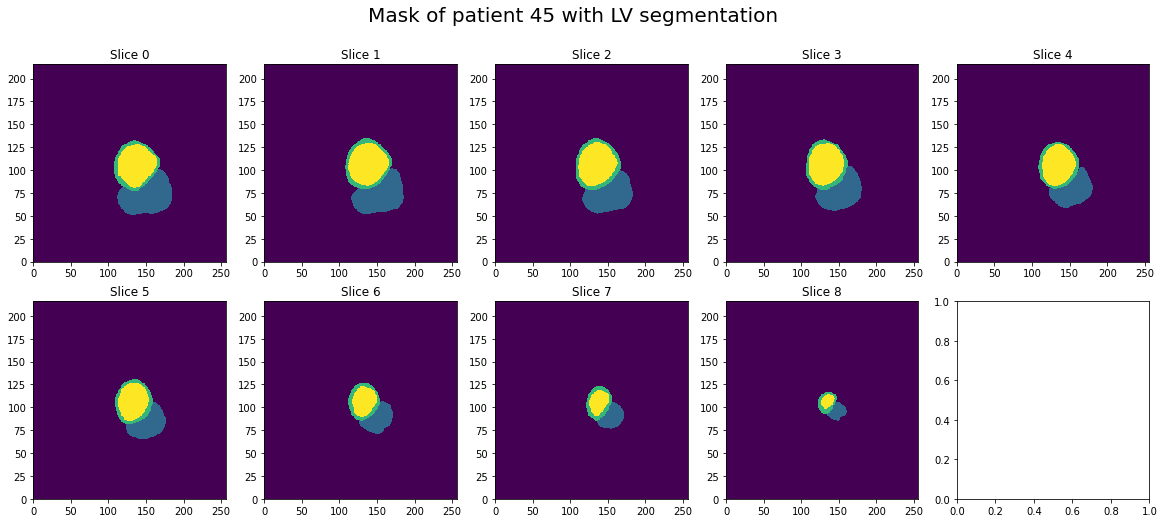

In [103]:
from scipy.ndimage import binary_fill_holes
from skimage.measure import label, regionprops

patient_idx=45
myo_idx=2 # Myocardium index in the mask
lv_idx=3 # Left ventricle index in the mask
mri=mri_test[patient_idx][mri_idx]
mask=mri_test[patient_idx][mask_idx]

mask_myo=(mask==myo_idx).astype(int)
mask_props=np.array([regionprops(mask_myo[1]) for i in range (mask_myo.shape[0])])
mask_centroids=np.array([mask_props[i][0].centroid for i in range (mask_myo.shape[0])])
mask_filled=np.array([(binary_fill_holes(mask_myo[i])-mask_myo[i])*lv_idx for i in range (mask_myo.shape[0])])
new_mask=mask+mask_filled

plot_slices(mask, title=f'Mask of patient {patient_idx} without LV segmentation')
plot_slices(new_mask, title=f'Mask of patient {patient_idx} with LV segmentation')

In [68]:
mask_filled.shape

(10, 256, 216)

---

We plot height and weight for each category 

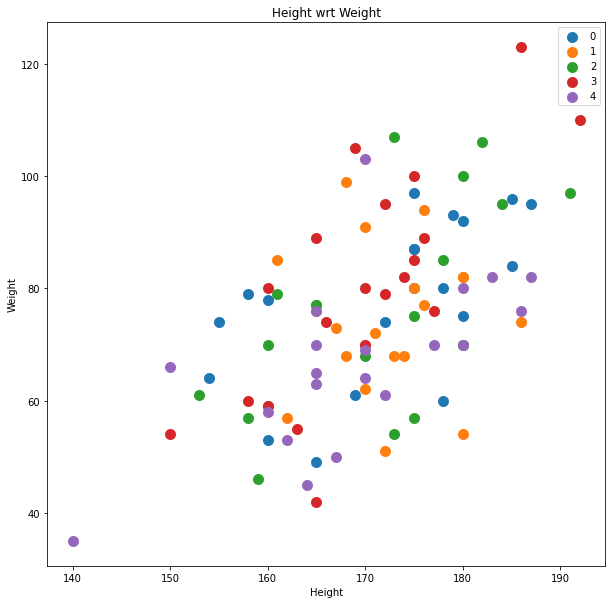

In [8]:
plt.figure(figsize=(10,10))
for i in range(len(X_cat)):
    plt.scatter(X_cat[i][:,0], X_cat[i][:,1], label=str(i), linewidths=5)
plt.xlabel('Height')
plt.ylabel('Weight')
plt.title('Height wrt Weight')
plt.legend()
plt.show()

There seem to be no easy way to separate data into distinct categories only according to there distribution.<br>
It justifies the fact that we need to extract features from heart MRIs to seperate categories.

## Features extraction